In [10]:
# ipython
%matplotlib inline
%precision 4

# imports
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.linalg import inv
from scipy.spatial import Delaunay
from my_animate import animate_array, dual_animate
from IPython.display import HTML
from itertools import count

# matplotlib preferences
mpl.rcdefaults()  # reset
plt.rc('axes', titlesize=20, labelsize=15)
plt.rc('axes.formatter', limits=[-4, 4])
plt.rc('ytick', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('lines', linewidth=1, markersize=5)
plt.rc('figure', figsize=(5, 5))
# print(plt.rcParams) # all parameters


## Coursework 3C - 2D mesh optimisation

To begin with I will just implement the system given. I will also test a method to identify boundary nodes by requiring an edge node is on a circle of radius close to a given radius (in this case 1).

In [11]:
points = np.array([[-5.80648777e-01,  4.58163020e-01],
                   [-4.49366978e-01, -8.78260592e-01],
                   [ 1.25344404e-01, -8.11594100e-01],
                   [ 6.59107579e-01,  4.40484354e-01],
                   [-4.50759558e-01,  2.28830048e-01],
                   [ 2.39877465e-01,  4.47880691e-01],
                   [ 5.57255517e-01, -8.12278273e-01],
                   [ 1.16512866e-01, -7.15055733e-01],
                   [ 8.74019766e-01, -3.69078360e-01],
                   [ 8.07618256e-01, -5.28387559e-01],
                   [-1.35044590e-01,  1.65036839e-01],
                   [ 2.64544176e-01,  1.66414371e-01],
                   [ 4.33723660e-01,  1.76408613e-01],
                   [ 5.07178633e-01,  1.81359072e-01],
                   [-6.36539072e-03, -4.40344606e-02],
                   [-3.27218295e-01, -1.94144945e-01],
                   [ 1.98845151e-01,  1.14897057e-01],
                   [ 3.42407131e-01,  1.38783108e-01],
                   [-1.47793003e-01, -5.74951448e-02],
                   [-8.43598091e-01, -4.37604895e-01],
                   [ 9.51056516e-01,  3.09016994e-01],
                   [ 8.09016994e-01,  5.87785252e-01],
                   [ 5.87785252e-01,  8.09016994e-01],
                   [ 3.09016994e-01,  9.51056516e-01],
                   [ 6.12323400e-17,  1.00000000e+00],
                   [-3.09016994e-01,  9.51056516e-01],
                   [-5.87785252e-01,  8.09016994e-01],
                   [-8.09016994e-01,  5.87785252e-01],
                   [-9.51056516e-01,  3.09016994e-01],
                   [-1.00000000e+00,  1.22464680e-16],
                   [-9.51056516e-01, -3.09016994e-01],
                   [-8.09016994e-01, -5.87785252e-01],
                   [-5.87785252e-01, -8.09016994e-01],
                   [-3.09016994e-01, -9.51056516e-01],
                   [-1.83697020e-16, -1.00000000e+00],
                   [ 3.09016994e-01, -9.51056516e-01],
                   [ 5.87785252e-01, -8.09016994e-01],
                   [ 8.09016994e-01, -5.87785252e-01],
                   [ 9.51056516e-01, -3.09016994e-01],
                   [ 1.00000000e+00, -2.44929360e-16]])

[Text(0,0.5,'Y'), Text(0.5,0,'X'), Text(0.5,1,'Given mesh')]

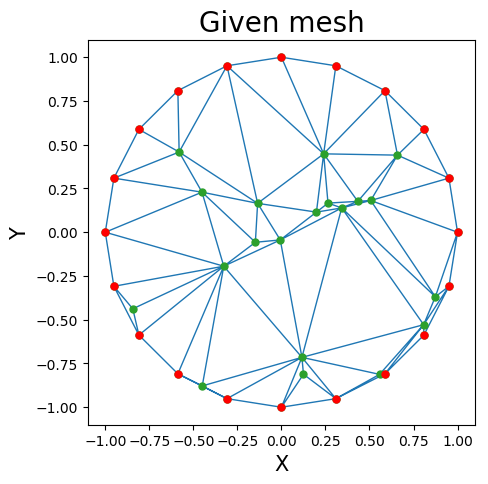

In [12]:
# setup the tri_grid 
tri = Delaunay(points, incremental=True)

# plot the grid
fig, ax = plt.subplots()
ax.triplot(points[:, 0], points[:, 1], tri.simplices, label='Edges')
ax.plot(points[:, 0], points[:, 1], 'o', label='Nodes')

# identify the edge nodes
edge_nodes = np.array([p for p in points if np.isclose(sum(p**2), 1)])
plt.plot(edge_nodes[:, 0], edge_nodes[:, 1], 'ro', label='Edge Nodes')

# titles
plt.gca().set(title='Given mesh', xlabel='X', ylabel='Y')


To find all the angles in this system I will use the cosign rule and loop over all triangles in the Delaunay object.

In [13]:
def angles(tri_obj):
    "Given a Delaunay object this finds all the angles of its mesh"
    # set up
    points = tri_obj.points
    triangles = tri_obj.vertices
    angles = []
    cosine_rule = lambda a,b,c : np.arccos((b**2 + c**2 - a**2) / (2*b*c)) * 180/np.pi
    
    # loop over every triangle
    for js in triangles:
        vertexs = points[js]
        tmp = np.roll(vertexs, 1, axis=0)
        edge_vecs = vertexs - tmp  # edge vectors
        a, b, c = np.sqrt((edge_vecs**2).sum(axis=1))  # edge lengths
        angles += [cosine_rule(a,b,c), cosine_rule(b,c,a), cosine_rule(c,a,b)]
    return angles

angle limits =  (0.41460750280587483, 179.16185414544876)


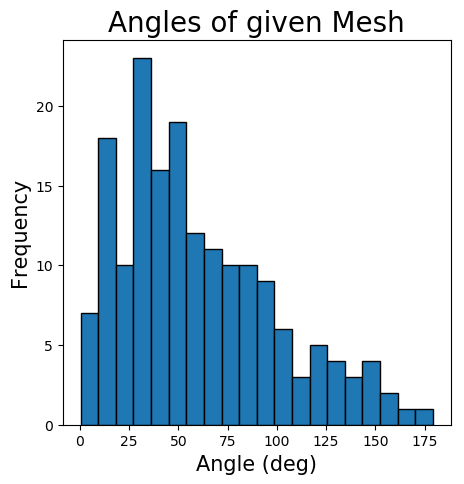

In [14]:
# plot the angles for the given mesh
angs = angles(tri)
plt.hist(angs, bins=20, ec='k')
plt.gca().set(title='Angles of given Mesh', xlabel='Angle (deg)', ylabel='Frequency')
print('angle limits = ', (min(angs), max(angs)))

Laplacian Smoothing involve making the value of a point the average of its connected points values. In the examples given a relaxation factor is used as this is an iterative method.

In [15]:
def smooth_iterate(tri_obj, relax, radius):
    # localy define the points, neighbour arrays and setup soluion array
    points = tri_obj._points
    indices, indptr = tri_obj.vertex_neighbor_vertices  # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.Delaunay.vertex_neighbor_vertices.html#scipy.spatial.Delaunay.vertex_neighbor_vertices
    new_points = np.empty_like(points)
    
    # loop over every point
    for i, p in enumerate(points):
        if not np.isclose(sum(p**2), radius):  # if not a boundary
            adjasent_points = indptr[indices[i]:indices[i+1]]
            mean = np.mean(points[adjasent_points], axis=0)
            new_points[i] = (1-relax)*p + relax*mean
        else:  # dont move the boundary nodes
            new_points[i] = p
    return new_points

angle limits =  (20.341125805445525, 135.14386893393686)


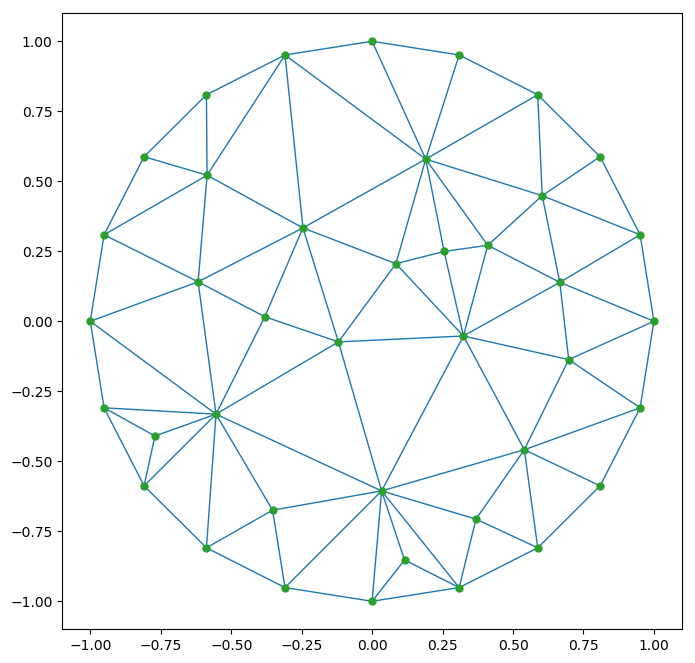

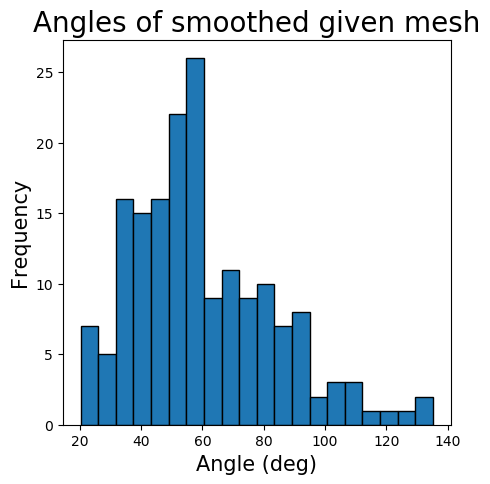

In [16]:
# iterate 100 times
for _ in range(100):
    tri._points = smooth_iterate(tri, relax=0.1, radius=1)

# plot the grid
points = tri._points
fig, ax = plt.subplots(figsize=(8,8))
ax.triplot(points[:, 0], points[:, 1], tri.simplices)
ax.plot(points[:, 0], points[:, 1], 'o')

# plot the angle distribution
angs = angles(tri)
fig, ax = plt.subplots()
plt.hist(angs, bins=20, ec='k')
plt.gca().set(title='Angles of smoothed given mesh', xlabel='Angle (deg)', ylabel='Frequency')
print('angle limits = ', (min(angs), max(angs)))

A better algorithm should include some kind of convergence criteria rather than simply iterating a set number of times. Seeing as we are looking at the distribution of angles it seems reasonable that the convergence criteria is to do with that distribution. Hence I will choose to use the standard deviation of the whole distribution as the convergence criteria

In [19]:
def smooth_converge(tri_obj, relax=0.1, radius=1, tol=1e-5, itercap = int(1e4)):
    "smooth the given mesh till the standard deviation of the angles is less than the tolerence"
    std_diff = tol*2
    std_old = np.std(angles(tri_obj))
    count = 0
    
    # iterate till maximum iteration cap
    while (std_diff > tol) and count < itercap:
        count += 1
        tri_obj._points = smooth_iterate(tri_obj, relax, radius)
        if count % 10 == 0:
            tmp = np.std(angles(tri_obj))
            std_diff = abs(std_old - tmp)
            std_old = tmp
            print('at iteration %i, std = %f' % (count, tmp))
    print('Convergence reached after %i iterations with std = %f' % (count, tmp))

at iteration 10, std = 20.820007
at iteration 20, std = 20.697529
at iteration 30, std = 20.670935
at iteration 40, std = 20.664374
at iteration 50, std = 20.663775
at iteration 60, std = 20.665207
at iteration 70, std = 20.667265
at iteration 80, std = 20.669386
at iteration 90, std = 20.671344
at iteration 100, std = 20.673060
at iteration 110, std = 20.674521
at iteration 120, std = 20.675746
at iteration 130, std = 20.676762
at iteration 140, std = 20.677598
at iteration 150, std = 20.678283
at iteration 160, std = 20.678843
at iteration 170, std = 20.679300
at iteration 180, std = 20.679671
at iteration 190, std = 20.679973
at iteration 200, std = 20.680219
at iteration 210, std = 20.680418
at iteration 220, std = 20.680580
at iteration 230, std = 20.680712
at iteration 240, std = 20.680818
at iteration 250, std = 20.680905
at iteration 260, std = 20.680975
at iteration 270, std = 20.681032
at iteration 280, std = 20.681078
at iteration 290, std = 20.681115
at iteration 300, std =

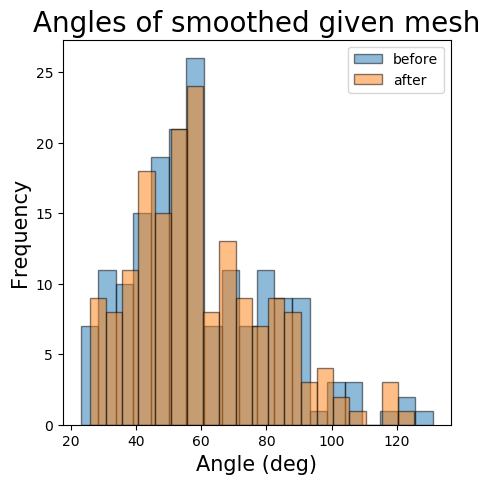

In [20]:
# reset the system
tri = Delaunay(points, incremental=True)
angs_before = angles(tri)

# smooth with convergence
smooth_converge(tri)
angs_after = angles(tri)

# plot the angle distribution
fig, ax = plt.subplots()
plt.hist(angs_before, bins=20, ec='k', alpha=0.5, label='before')
plt.hist(angs_after, bins=20, ec='k', alpha=0.5, label='after')
plt.gca().set(title='Angles of smoothed given mesh', xlabel='Angle (deg)', ylabel='Frequency')
plt.legend()
print('angle limits before = ', (min(angs_before), max(angs_before)))
print('angle limits before = ', (min(angs_after), max(angs_after)))

Though the angle limits appear worse than previously the distribution is visually better on the histogram. It is worth noting that the even in the steady state there are still large angles, mainly due to triangles within triangles which will have angles near $120$ degrees on the center points.

To test my code a bit further I will generate a random graph using the same boundary nodes as the above problem and implement Laplacian smoothing on it.

at iteration 10, std = 21.631859
at iteration 20, std = 20.802555
at iteration 30, std = 20.638669
at iteration 40, std = 20.564337
at iteration 50, std = 20.518715
at iteration 60, std = 20.488396
at iteration 70, std = 20.467534
at iteration 80, std = 20.452877
at iteration 90, std = 20.442421
at iteration 100, std = 20.434865
at iteration 110, std = 20.429341
at iteration 120, std = 20.425260
at iteration 130, std = 20.422218
at iteration 140, std = 20.419932
at iteration 150, std = 20.418202
at iteration 160, std = 20.416887
at iteration 170, std = 20.415883
at iteration 180, std = 20.415114
at iteration 190, std = 20.414523
at iteration 200, std = 20.414068
at iteration 210, std = 20.413718
at iteration 220, std = 20.413448
at iteration 230, std = 20.413240
at iteration 240, std = 20.413079
at iteration 250, std = 20.412955
at iteration 260, std = 20.412859
at iteration 270, std = 20.412785
at iteration 280, std = 20.412727
at iteration 290, std = 20.412683
at iteration 300, std =

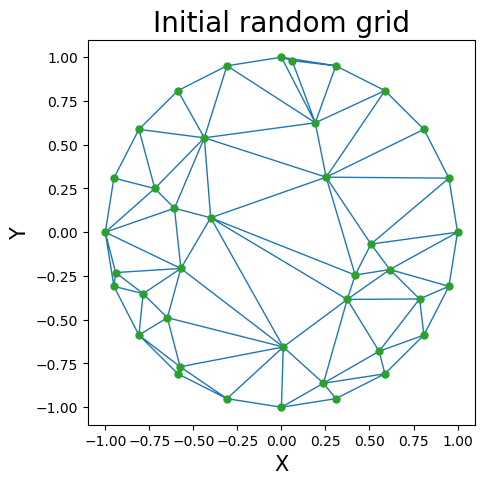

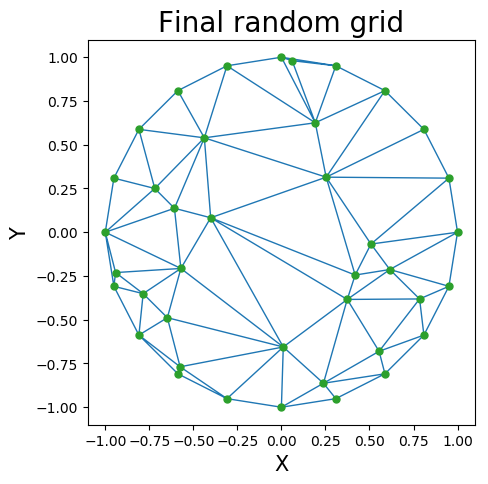

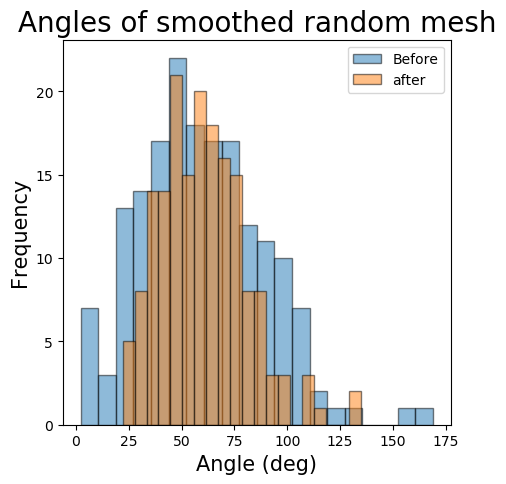

In [21]:
# begin with the edge nodes
nodes = np.array([p for p in points if np.isclose(sum(p**2), 1)])

# generate the random interior points
n = 25
random_vals = np.random.random(n*2).reshape(n,2) * 2 - 1  # to make values between [-1, 1]
interior_nodes = random_vals[np.where((random_vals**2).sum(axis=1) <= 1)[0]]

# make the tri_grid
points_random = np.vstack((nodes, interior_nodes))
tri_random = Delaunay(points_random, incremental=True)
angs_initial = angles(tri_random)

# plot the initial grid
fig, ax = plt.subplots()
ax.triplot(points_random[:, 0], points_random[:, 1], tri_random.simplices, label='Edges')
ax.plot(points_random[:, 0], points_random[:, 1], 'o', label='Nodes')
ax.set(title='Initial random grid', xlabel='X', ylabel='Y')

# smooth 
smooth_converge(tri_random)
angs_final = angles(tri_random)

# plot the final grid
fig, ax = plt.subplots()
ax.triplot(points_random[:, 0], points_random[:, 1], tri_random.simplices, label='Edges')
ax.plot(points_random[:, 0], points_random[:, 1], 'o', label='Nodes')
ax.set(title='Final random grid', xlabel='X', ylabel='Y')

# plot the angle distribution
fig, ax = plt.subplots()
plt.hist(angs_initial, bins=20, ec='k', alpha=0.5, label='Before')
plt.hist(angs_final, bins=20, ec='k', alpha=0.5, label='after')
ax.set(title='Angles of smoothed random mesh', xlabel='Angle (deg)', ylabel='Frequency')
ax.legend()
print('angle limits before = ', (min(angs_initial), max(angs_initial)))
print('angle limits before = ', (min(angs_final), max(angs_final)))

The results seem reasonable, the angle distribution has a lower standard deviation (is more bunched together).